# SISTEM PEMBACA GAMBAR UNTUK PENYANDANG TUNANETRA

**Capstone Project**  
LASKAR AI  


## Deskripsi Proyek

Notebook ini merupakan implementasi dari capstone project yang berjudul **"SISTEM PEMBACA GAMBAR UNTUK PENYANDANG TUNANETRA"**.

Tujuan dari proyek ini adalah untuk mengembangkan sistem yang mampu menghasilkan narasi berdasarkan input berupa gambar. Proses ini dilakukan melalui dua tahap utama:

1. **Ekstraksi Fitur Gambar** menggunakan arsitektur CNN seperti ResNet atau VGG untuk mendapatkan representasi visual dari gambar.
2. **Generasi Teks Otomatis** menggunakan model GPT-2 yang telah disesuaikan (fine-tuned) untuk menghasilkan kalimat atau paragraf berdasarkan fitur visual tersebut.

Proyek ini menggabungkan pendekatan computer vision dan natural language processing untuk mengeksplorasi potensi AI dalam membantu proses kreatif penceritaan.

Notebook ini mencakup:
- Pemrosesan dan pelatihan model CNN untuk ekstraksi fitur gambar
- Fine-tuning GPT-2 untuk menghasilkan teks dari fitur
- Evaluasi hasil keluaran sistem
- Contoh output cerita dari berbagai jenis gambar



# **1. Import Library**

In [ ]:
pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import seaborn as sns
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# **2. Memuat Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Skripsi/dataset.csv")
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,images_102_jpg.rf.4f1b39e7e857db8a565bd091e61a...,640,640,langit,27,24,612,218
1,images_102_jpg.rf.4f1b39e7e857db8a565bd091e61a...,640,640,gunung,134,283,297,335
2,images_102_jpg.rf.4f1b39e7e857db8a565bd091e61a...,640,640,gunung,355,248,640,330
3,images_358_jpg.rf.8c59b78881421a74c1180e632dc4...,640,640,danau,0,306,640,640
4,images_358_jpg.rf.8c59b78881421a74c1180e632dc4...,640,640,gunung,0,32,640,319


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3407 entries, 0 to 3406
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  3407 non-null   object
 1   width     3407 non-null   int64 
 2   height    3407 non-null   int64 
 3   class     3407 non-null   object
 4   xmin      3407 non-null   int64 
 5   ymin      3407 non-null   int64 
 6   xmax      3407 non-null   int64 
 7   ymax      3407 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 213.1+ KB


# **3. Exploratory Data Analysis (EDA)**

## Mengecek apakah ada nilai kosong dan duplikasi data

In [ ]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 filename    0
width       0
height      0
class       0
xmin        0
ymin        0
xmax        0
ymax        0
dtype: int64


In [ ]:
print("\nApakah ada duplikat?")
print(df.duplicated().sum())


Apakah ada duplikat?
0


## Mengecek distribusi kelas

In [ ]:
print("Unique object classes:", df['class'].unique())

Unique object classes: ['langit' 'gunung' 'danau' 'sungai' 'batu' 'laut' 'pohon']


In [ ]:
print(df['class'].value_counts())

class
pohon     576
batu      521
sungai    515
langit    505
laut      496
gunung    473
danau     321
Name: count, dtype: int64


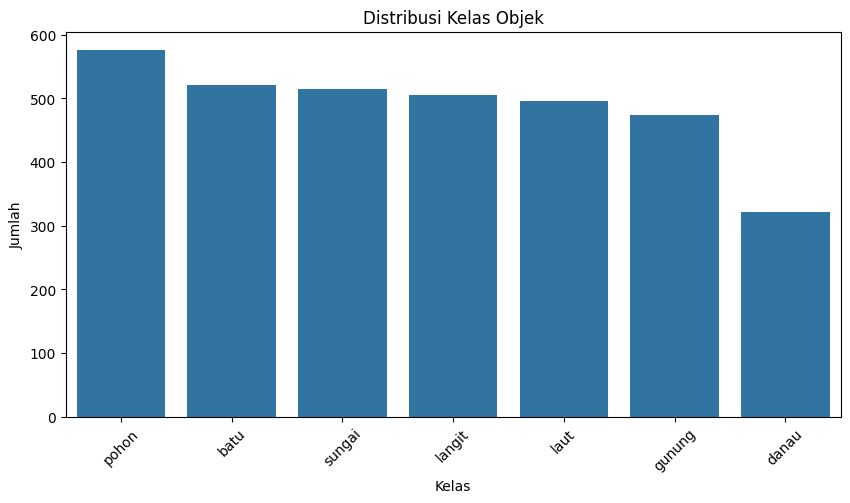

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='class', order=df['class'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribusi Kelas Objek")
plt.xlabel("Kelas")
plt.ylabel("Jumlah")
plt.show()

## Mengecek ukuran gambar

In [ ]:
df[['width', 'height']].describe()

,width,height
count,3407.0,3407.0
mean,640.0,640.0
std,0.0,0.0
min,640.0,640.0
25%,640.0,640.0
50%,640.0,640.0
75%,640.0,640.0
max,640.0,640.0


## Distribusi ukuran bounding box

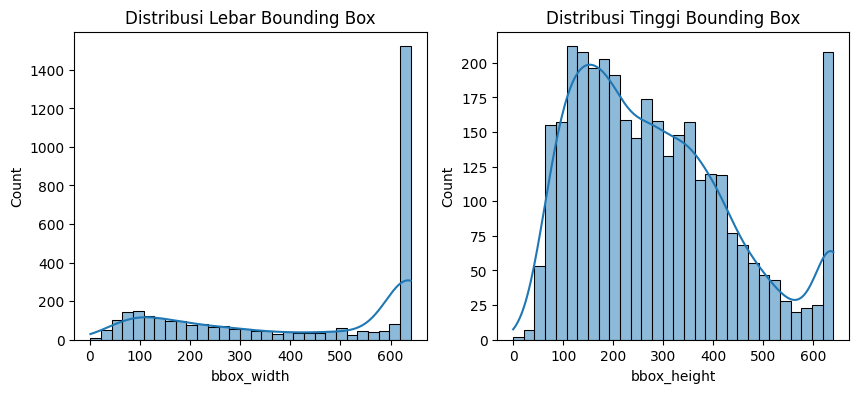

In [ ]:
df['bbox_width'] = df['xmax'] - df['xmin']
df['bbox_height'] = df['ymax'] - df['ymin']

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(df['bbox_width'], bins=30, kde=True)
plt.title("Distribusi Lebar Bounding Box")

plt.subplot(1,2,2)
sns.histplot(df['bbox_height'], bins=30, kde=True)
plt.title("Distribusi Tinggi Bounding Box")
plt.show()


## Visualisasi Beberapa Gambar dan Bounding Box-nya

In [ ]:
def visualize_bbox(image_path, bboxes, labels):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    for bbox, label in zip(bboxes, labels):
        xmin, ymin, xmax, ymax = bbox
        width, height = xmax - xmin, ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin - 5, label, color="red", fontsize=12, bbox=dict(facecolor="white", alpha=0.5))

    plt.show()


Tampilkan gambar dengan bounding box

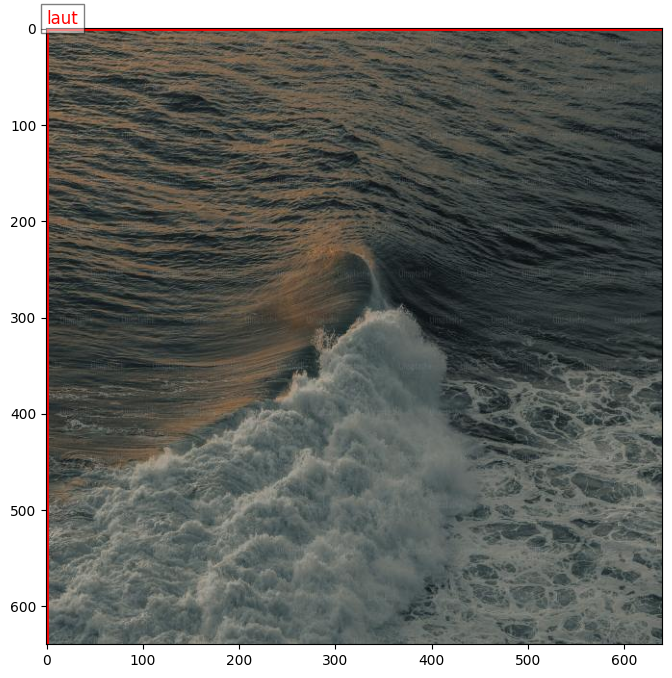

In [ ]:
sample_filename = df.sample(1)["filename"].values[0]
sample_df = df[df["filename"] == sample_filename]
image_path = f"/content/drive/MyDrive/Skripsi/Image/{sample_filename}"

bboxes = sample_df[["xmin", "ymin", "xmax", "ymax"]].values
labels = sample_df["class"].values

visualize_bbox(image_path, bboxes, labels)


## Jumlah Objek per Gambar

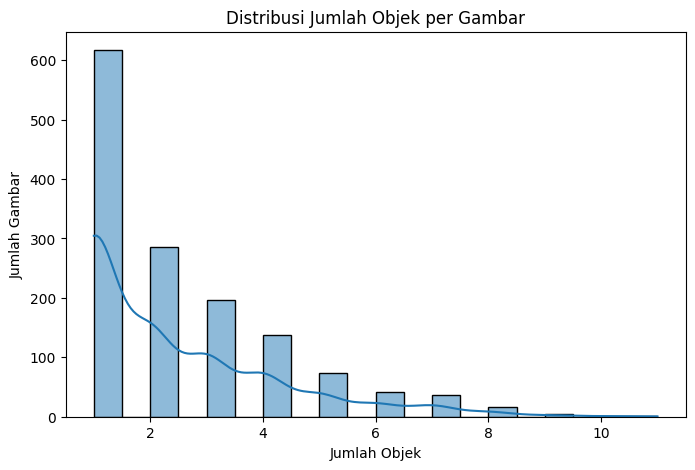

Rata-rata objek per gambar: 2.4128895184135977


In [ ]:
obj_per_image = df.groupby('filename').size()

plt.figure(figsize=(8,5))
sns.histplot(obj_per_image, bins=20, kde=True)
plt.title("Distribusi Jumlah Objek per Gambar")
plt.xlabel("Jumlah Objek")
plt.ylabel("Jumlah Gambar")
plt.show()

print("Rata-rata objek per gambar:", obj_per_image.mean())


## Proporsi Luas Bounding Box terhadap Gambar

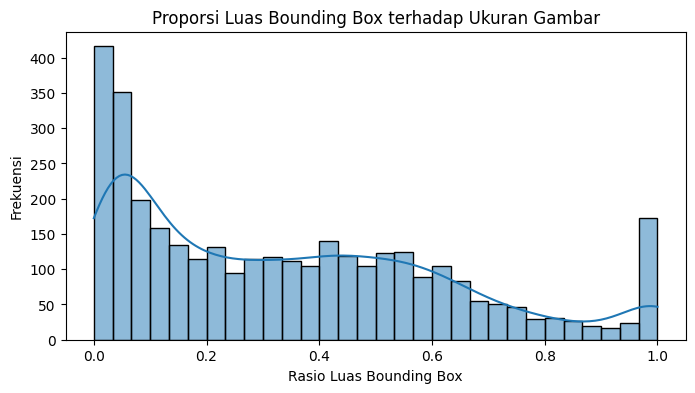

In [ ]:
df['bbox_area'] = df['bbox_width'] * df['bbox_height']
df['img_area'] = df['width'] * df['height']
df['bbox_ratio'] = df['bbox_area'] / df['img_area']

plt.figure(figsize=(8,4))
sns.histplot(df['bbox_ratio'], bins=30, kde=True)
plt.title("Proporsi Luas Bounding Box terhadap Ukuran Gambar")
plt.xlabel("Rasio Luas Bounding Box")
plt.ylabel("Frekuensi")
plt.show()


## Cek Posisi Objek (Koordinat XY)

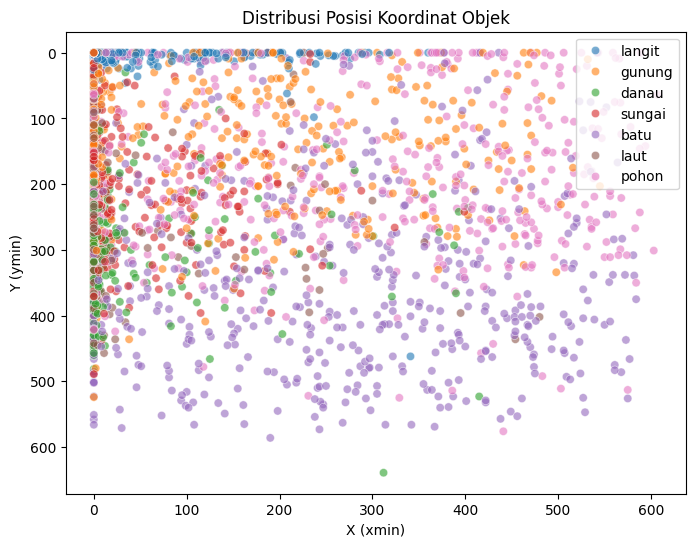

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='xmin', y='ymin', hue='class', alpha=0.6)
plt.title("Distribusi Posisi Koordinat Objek")
plt.xlabel("X (xmin)")
plt.ylabel("Y (ymin)")
plt.gca().invert_yaxis()  # karena 0,0 di pojok kiri atas pada gambar
plt.legend(loc='upper right')
plt.show()

## Word Cloud dari Kelas

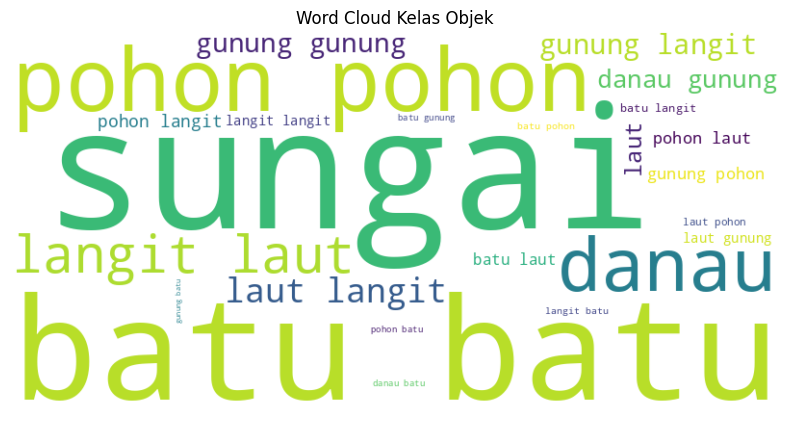

In [ ]:
from wordcloud import WordCloud

text = " ".join(df['class'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud Kelas Objek")
plt.show()


# **4. Pra-Pemrosesan Data**

## Preprocessing Gambar

Pada tahap ini, setiap gambar diproses agar memiliki dimensi tetap (224x224 piksel) dan format warna RGB. Gambar juga dinormalisasi ke rentang [0, 1] agar sesuai dengan input standar model CNN. Jika gambar tidak ditemukan, sistem akan otomatis menggantinya dengan gambar kosong (berwarna hitam) sebagai penanganan error.


In [ ]:
IMAGE_SIZE = 224
MAX_OBJECTS = 11  # Jumlah maksimal objek per gambar

# Fungsi untuk memuat dan memproses gambar
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:  # Jika gambar tidak ditemukan
        print(f"Warning: {image_path} tidak ditemukan!")
        return np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3))  # Placeholder gambar hitam
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konversi ke RGB
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Resize
    img = img / 255.0  # Normalisasi
    return img


## Mapping Label Kelas

Pada tahap ini, setiap label kelas (seperti "gunung", "langit", dll.) yang ada pada dataset diubah menjadi representasi numerik untuk memudahkan pemrosesan model. Setiap kelas dipetakan ke ID unik menggunakan dictionary `class_mapping`, yang kemudian ditambahkan ke dataset dalam kolom baru bernama `class_id`.


In [ ]:
class_labels = list(df['class'].unique())
class_labels.append('no_object')  # Tambah manual
class_mapping = {label: idx for idx, label in enumerate(class_labels)}
df['class_id'] = df['class'].map(class_mapping)

In [ ]:
print(class_mapping)

{'langit': 0, 'gunung': 1, 'danau': 2, 'sungai': 3, 'batu': 4, 'laut': 5, 'pohon': 6, 'no_object': 7}


In [ ]:
# Cek apakah berhasil
print(df[['class', 'class_id']].head())

    class  class_id
0  langit         0
1  gunung         1
2  gunung         1
3   danau         2
4  gunung         1


## Pengelompokan Data Gambar dan Bounding Box

Pada tahap ini, gambar, bounding box, dan label kelas dikelompokkan berdasarkan nama file gambar. Setiap bounding box dinormalisasi sesuai dengan ukuran gambar agar konsisten dalam rentang [0, 1]. Label kelas juga dikodekan menggunakan teknik **one-hot encoding** untuk mempermudah pemrosesan lebih lanjut. Semua data ini kemudian disimpan dalam tiga dictionary terpisah: `image_data_dict` untuk gambar, `bbox_dict` untuk bounding box, dan `class_dict` untuk label kelas. Dengan cara ini, setiap gambar dapat dengan mudah diakses bersama dengan informasi objek yang terkandung di dalamnya.


In [ ]:
image_data_dict = {}
bbox_dict = {}
class_dict = {}

# Loop melalui dataset untuk mengelompokkan bounding boxes dan kelas per gambar
for idx, row in df.iterrows():
    image_path = f"/content/drive/MyDrive/Skripsi/Image/{row['filename']}"  # Sesuaikan path dengan lokasi dataset
    img = load_and_preprocess_image(image_path)

    # Normalisasi bounding box berdasarkan ukuran gambar asli
    bbox = [
        row['xmin'] / row['width'],
        row['ymin'] / row['height'],
        row['xmax'] / row['width'],
        row['ymax'] / row['height']
    ]

    class_one_hot = to_categorical(row['class_id'], num_classes=len(class_labels))  # One-hot encoding kelas

    # Jika gambar sudah ada di dictionary, tambahkan objek ke dalamnya
    if row['filename'] in image_data_dict:
        bbox_dict[row['filename']].append(bbox)
        class_dict[row['filename']].append(class_one_hot)
    else:
        image_data_dict[row['filename']] = img
        bbox_dict[row['filename']] = [bbox]  # List bounding box
        class_dict[row['filename']] = [class_one_hot]  # List one-hot label kelas


## Padding pada Bounding Box dan Kelas

Fungsi ini digunakan untuk memastikan bahwa setiap gambar memiliki jumlah objek yang konsisten dengan menambahkan padding pada bounding box dan label kelas. Jika jumlah objek dalam gambar kurang dari batas maksimum yang telah ditentukan (dalam hal ini, 11 objek per gambar), fungsi ini akan menambahkan nilai padding yang telah ditentukan (misalnya, array kosong atau nol) hingga mencapai panjang yang diinginkan. Dengan cara ini, dataset menjadi seragam dan siap untuk dimasukkan ke dalam model.


In [ ]:
# Fungsi untuk padding bounding boxes dan kelas
def pad_sequence(data_list, target_length, pad_value):
    data_list = list(data_list)
    if len(data_list) < target_length:
        pad_amount = target_length - len(data_list)
        data_list.extend([pad_value] * pad_amount)  # Tambahkan padding
    return np.array(data_list)

## Konversi ke Numpy Array dengan Padding

Setelah data gambar, bounding box, dan kelas dikelompokkan, langkah selanjutnya adalah mengonversinya menjadi format numpy array untuk mempermudah pemrosesan model. Gambar dikonversi menjadi array dengan dimensi `(N, 224, 224, 3)`, di mana N adalah jumlah gambar. Bounding box dan label kelas kemudian dipad dengan menggunakan fungsi `pad_sequence`, memastikan setiap gambar memiliki jumlah objek yang konsisten (maksimal 11 objek). Hasil akhirnya adalah array `y_bbox` dengan dimensi `(N, 11, 4)` untuk bounding box, dan array `y_class` dengan dimensi `(N, 11, jumlah_kelas)` untuk label kelas.


In [ ]:
# Konversi ke numpy array dengan padding
image_data = np.array(list(image_data_dict.values()))  # (N, 224, 224, 3)
y_bbox = np.array([pad_sequence(bbox, MAX_OBJECTS, [0, 0, 0, 0]) for bbox in bbox_dict.values()])  # (N, 11, 4)
no_object_one_hot = np.eye(len(class_labels))[-1]

y_class = np.array([
    pad_sequence(cls, MAX_OBJECTS, no_object_one_hot)
    for cls in class_dict.values()
])


In [ ]:
for i, bbox in enumerate(bbox_dict.values()):
    try:
        b = pad_sequence(bbox, MAX_OBJECTS, [0, 0, 0, 0])
        if np.array(b).shape != (MAX_OBJECTS, 4):
            print(f"Index {i}: shape mismatch, got {np.array(b).shape}")
    except Exception as e:
        print(f"Index {i}: Error: {e}")


In [ ]:
# Cek kesesuaian jumlah data
print("Jumlah gambar:", image_data.shape)
print("Jumlah bounding box:", y_bbox.shape)
print("Jumlah label kelas:", y_class.shape)

# Pastikan jumlahnya sama sebelum membagi data
assert len(image_data) == len(y_bbox) == len(y_class), "Jumlah data tidak cocok!"

Jumlah gambar: (1412, 224, 224, 3)
Jumlah bounding box: (1412, 11, 4)
Jumlah label kelas: (1412, 11, 8)


In [ ]:
# Menampilkan sample pertama dari dataset
idx = 9

print(f"Gambar ke-{idx}:")
print("Bounding Box:", y_bbox[idx])    # Array bounding box untuk gambar ini
print("Label Kelas:", y_class[idx])    # Array one-hot encoding kelas untuk gambar ini

Gambar ke-9:
Bounding Box: [[0.0828125 0.175     0.8546875 0.675    ]
 [0.0453125 0.        1.        0.2421875]
 [0.        0.        0.        0.       ]
 [0.        0.        0.        0.       ]
 [0.        0.        0.        0.       ]
 [0.        0.        0.        0.       ]
 [0.        0.        0.        0.       ]
 [0.        0.        0.        0.       ]
 [0.        0.        0.        0.       ]
 [0.        0.        0.        0.       ]
 [0.        0.        0.        0.       ]]
Label Kelas: [[0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [ ]:
print("Sample label (kelas):", y_class[-1])
print("Index max di setiap label:", [np.argmax(cls) for cls in y_class[-1]])

Sample label (kelas): [[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
Index max di setiap label: [np.int64(2), np.int64(1), np.int64(6), np.int64(6), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7), np.int64(7)]


# 5. Splitting Data

In [ ]:
X_train, X_val, y_bbox_train, y_bbox_val, y_class_train, y_class_val = train_test_split(
    image_data, y_bbox, y_class, test_size=0.2, random_state=42
)

print("Training set:", X_train.shape)
print("Testing set:", X_val.shape)

Training set: (1129, 224, 224, 3)
Testing set: (283, 224, 224, 3)


#6. Pembuatan Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def build_model(input_shape, num_classes, max_objects):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Stabil: GAP
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)

    # Output tanpa aktivasi keras
    bbox_output = layers.Dense(max_objects * 4, name="bbox_dense")(x)
    bbox_output = layers.Reshape((max_objects, 4), name="bbox_output")(bbox_output)

    class_output = layers.Dense(max_objects * num_classes, activation='softmax', name="class_dense")(x)
    class_output = layers.Reshape((max_objects, num_classes), name="class_output")(class_output)

    model = models.Model(inputs=inputs, outputs=[bbox_output, class_output])
    return model


# Buat model
model = build_model((224, 224, 3), num_classes=8, max_objects=11)

# Compile model
model.compile(optimizer='adam',
              loss={'bbox_output': 'mse', 'class_output': 'categorical_crossentropy'},
              metrics={'bbox_output': 'mae', 'class_output': 'accuracy'})

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 112, 112,  │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ dropout[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      4,224 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_dense (Dense)  │ (None, 44)        │      5,676 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_dense (Dense) │ (None, 88)        │     11,352 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_output         │ (None, 11, 4)     │          0 │ bbox_dense[0][0]  │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 11, 8)     │          0 │ class_dense[0][0] │
│ (Reshape)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 31,652 (123.64 KB)

 Trainable params: 31,524 (123.14 KB)

 Non-trainable params: 128 (512.00 B)

# 7. Pelatihan Model

In [ ]:
print(model.output_names)

ListWrapper(['bbox_output', 'class_output'])


In [ ]:
history = model.fit(
    X_train, {'bbox_output': y_bbox_train, 'class_output': y_class_train},
    validation_data=(X_val, {'bbox_output': y_bbox_val, 'class_output': y_class_val}),
    epochs=50,
    batch_size=16,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("deep_custom_model.keras", save_best_only=True)
    ]
)


Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - bbox_output_loss: 0.2207 - bbox_output_mae: 0.3496 - class_output_accuracy: 0.5097 - class_output_loss: 1.6287 - loss: 1.8581 - val_bbox_output_loss: 0.0520 - val_bbox_output_mae: 0.1277 - val_class_output_accuracy: 0.8102 - val_class_output_loss: 0.9816 - val_loss: 1.0410
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - bbox_output_loss: 0.1592 - bbox_output_mae: 0.3085 - class_output_accuracy: 0.8220 - class_output_loss: 0.6626 - loss: 0.8306 - val_bbox_output_loss: 0.0425 - val_bbox_output_mae: 0.1174 - val_class_output_accuracy: 0.8102 - val_class_output_loss: 0.6534 - val_loss: 0.7028
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - bbox_output_loss: 0.1036 - bbox_output_mae: 0.2434 - class_output_accuracy: 0.8136 - class_output_loss: 0.6585 - loss: 0.7706 - val_bbox_output_loss: 0.0455 - val_bbox_output_mae: 0.1143 - val_class_output_accuracy: 0.8102 - val_class_output_loss: 0.6599 - val_loss: 0.7120
Epoch 4/50
71/71 

# 8. Evaluasi Model

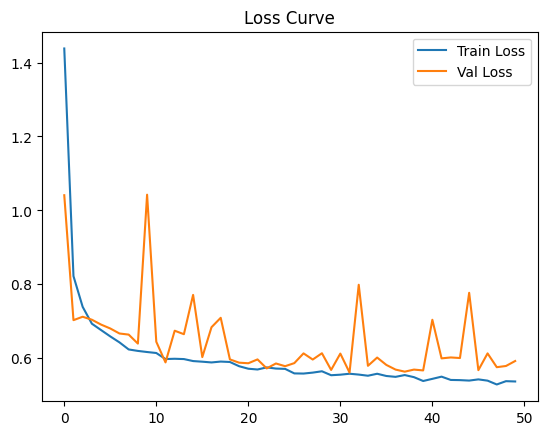

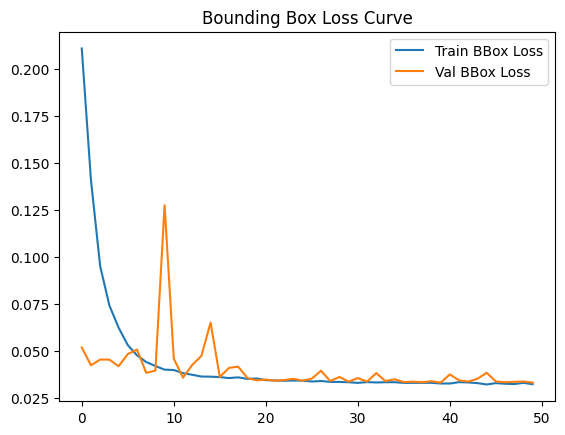

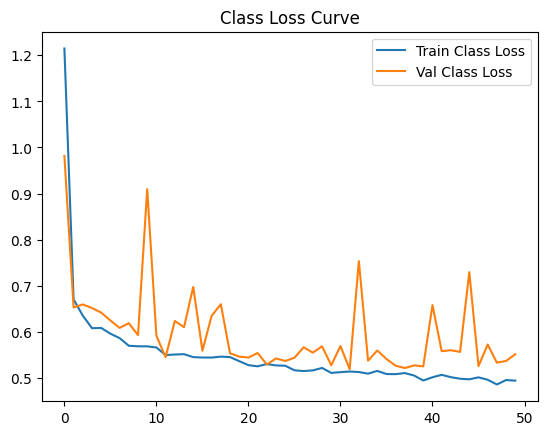

In [ ]:
# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

# Plot Bounding Box Loss
plt.plot(history.history['bbox_output_loss'], label='Train BBox Loss')
plt.plot(history.history['val_bbox_output_loss'], label='Val BBox Loss')
plt.legend()
plt.title('Bounding Box Loss Curve')
plt.show()

# Plot Class Loss
plt.plot(history.history['class_output_loss'], label='Train Class Loss')
plt.plot(history.history['val_class_output_loss'], label='Val Class Loss')
plt.legend()
plt.title('Class Loss Curve')
plt.show()


In [ ]:
def draw_bbox(image, pred_bboxes, pred_classes, true_bboxes, true_classes, class_labels):
    fig, ax = plt.subplots(1, figsize=(6,6))
    ax.imshow(image)

    # Ground Truth (warna hijau)
    for bbox, cls in zip(true_bboxes, true_classes):
        if not np.all(bbox == 0):
            rect = patches.Rectangle((bbox[0]*224, bbox[1]*224),
                                     (bbox[2]-bbox[0])*224,
                                     (bbox[3]-bbox[1])*224,
                                     linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
            ax.text(bbox[0]*224 + 2, bbox[1]*224 + 2,
                    f"GT: {class_labels[cls]}",
                    color='white', fontsize=8, weight='bold',
                    bbox=dict(facecolor='green', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2'))

    # Prediction (warna merah)
    for bbox, cls in zip(pred_bboxes, pred_classes):
        if not np.all(bbox == 0):
            rect = patches.Rectangle((bbox[0]*224, bbox[1]*224),
                                     (bbox[2]-bbox[0])*224,
                                     (bbox[3]-bbox[1])*224,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(bbox[0]*224 + 2, bbox[1]*224 + 20,
                    f"P: {class_labels[cls]}",
                    color='white', fontsize=8, weight='bold',
                    bbox=dict(facecolor='red', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2'))

    plt.axis('off')
    plt.title("Predicted vs Ground Truth Bounding Boxes")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


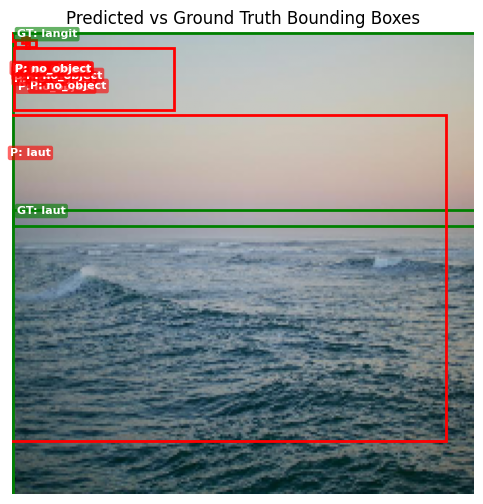

True Classes: [0 5 7 7 7 7 7 7 7 7 7]
True Classes Names: ['langit', 'laut', 'no_object', 'no_object', 'no_object', 'no_object', 'no_object', 'no_object', 'no_object', 'no_object', 'no_object']
Predicted Classes: [5 7 7 7 7 7 7 7 7 7 7]
Predicted Classes Names: ['laut', 'no_object', 'no_object', 'no_object', 'no_object', 'no_object', 'no_object', 'no_object', 'no_object', 'no_object', 'no_object']


In [ ]:
index = 55  # indeks gambar uji
image = X_val[index]
true_bboxes = y_bbox_val[index]
true_classes = np.argmax(y_class_val[index], axis=-1)
true_classes_names = [class_labels[i] for i in true_classes]

pred_bbox, pred_class = model.predict(np.expand_dims(image, axis=0))
pred_bbox = pred_bbox[0]
pred_classes = np.argmax(pred_class[0], axis=-1)
pred_classes_names = [class_labels[i] for i in pred_classes]

draw_bbox(image, pred_bbox, pred_classes, true_bboxes, true_classes, list(class_mapping.keys()))
print(f"True Classes: {true_classes}")
print(f"True Classes Names: {true_classes_names}")
print(f"Predicted Classes: {pred_classes}")
print(f"Predicted Classes Names: {pred_classes_names}")

In [ ]:
# Asumsikan kamu sudah punya data uji: X_test, y_bbox_test, y_class_test
results = model.evaluate(X_val, [y_bbox_val, y_class_val])
print("\n📊 Evaluasi Model:")
print(f"Bounding Box Loss (MSE): {results[1]:.4f}")
print(f"Bounding Box MAE: {results[3]:.4f}")
print(f"Class Loss (CrossEntropy): {results[2]:.4f}")
print(f"Class Accuracy: {results[4]:.4f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 275ms/step - bbox_output_loss: 0.0336 - bbox_output_mae: 0.0988 - class_output_accuracy: 0.8302 - class_output_loss: 0.5118 - loss: 0.5542

📊 Evaluasi Model:
Bounding Box Loss (MSE): 0.0336
Bounding Box MAE: 0.0983
Class Loss (CrossEntropy): 0.5175
Class Accuracy: 0.8314


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


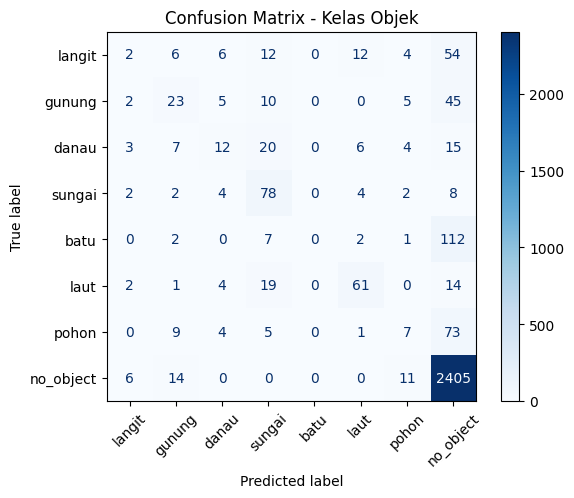


📋 Classification Report:
              precision    recall  f1-score   support

      langit       0.12      0.02      0.04        96
      gunung       0.36      0.26      0.30        90
       danau       0.34      0.18      0.24        67
      sungai       0.52      0.78      0.62       100
        batu       0.00      0.00      0.00       124
        laut       0.71      0.60      0.65       101
       pohon       0.21      0.07      0.11        99
   no_object       0.88      0.99      0.93      2436

    accuracy                           0.83      3113
   macro avg       0.39      0.36      0.36      3113
weighted avg       0.76      0.83      0.79      3113



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Prediksi
y_pred_bbox, y_pred_class = model.predict(X_val)

# Ambil prediksi kelas (argmax)
y_pred_class_argmax = np.argmax(y_pred_class, axis=-1)
y_true_class_argmax = np.argmax(y_class_val, axis=-1)

# Flatten dan filter padding
mask = ~(np.all(y_class_val == 0, axis=-1).flatten())
y_pred_flat = y_pred_class_argmax.flatten()[mask]
y_true_flat = y_true_class_argmax.flatten()[mask]


# Pastikan label lengkap dari mapping
labels = list(range(len(class_mapping)))  # [0, 1, 2, ..., 6]
label_names = list(class_mapping.keys())  # ['langit', 'gunung', ..., dst]

cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Kelas Objek")
plt.show()

# Classification report
print("\n📋 Classification Report:")
print(classification_report(
    y_true_flat,
    y_pred_flat,
    labels=labels,  # Ini penting agar selaras
    target_names=label_names,
    zero_division=0  # Untuk hindari error divide-by-zero jika kelas kosong
))



# 9. Pengujian Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Class Indices: [2, 6, 6, 7, 7, 7, 7, 7, 7, 7]
Predicted Class Names  : ['danau', 'pohon', 'pohon', 'no_object', 'no_object', 'no_object', 'no_object', 'no_object', 'no_object', 'no_object']
Confidence Scores       : [np.float32(0.002138797), np.float32(0.0020025433), np.float32(0.0051080463), np.float32(0.0025594286), np.float32(0.0052508004), np.float32(0.0069244504), np.float32(0.012878902), np.float32(0.057506777), np.float32(0.23814186), np.float32(0.5085379)]


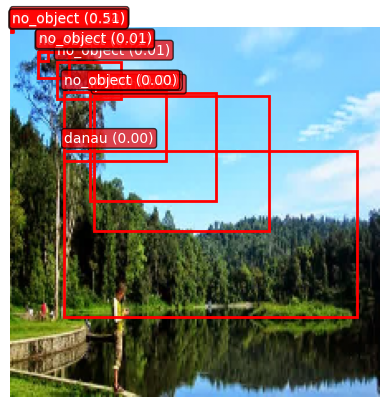

In [ ]:
def predict_and_visualize(image_path, model, class_labels, image_size=224, CONFIDENCE_THRESHOLD=0):
    img = load_and_preprocess_image(image_path)
    img_input = np.expand_dims(img, axis=0)

    pred_bbox, pred_class = model.predict(img_input)
    pred_bbox = pred_bbox[0]
    pred_class = pred_class[0]

    # Ambil label prediksi & confidence
    pred_class_labels = np.argmax(pred_class, axis=-1)
    confidence_scores = np.max(pred_class, axis=-1)

    # Filter hanya bounding box yang valid & confident
    valid_bboxes = []
    valid_class_indices = []
    valid_confidences = []

    for bbox, cls_idx, conf in zip(pred_bbox, pred_class_labels, confidence_scores):
        if np.sum(bbox) > 0 and conf >= CONFIDENCE_THRESHOLD:
            valid_bboxes.append(bbox)
            valid_class_indices.append(int(cls_idx))
            valid_confidences.append(conf)

    # Konversi ke nama kelas
    predicted_class_names = [class_labels[i] for i in valid_class_indices]

    # ✅ Tampilkan hasil
    print("Predicted Class Indices:", valid_class_indices)
    print("Predicted Class Names  :", predicted_class_names)
    print("Confidence Scores       :", valid_confidences)

    # Visualisasi
    plt.imshow(img)
    ax = plt.gca()

    for bbox, class_name, conf in zip(valid_bboxes, predicted_class_names, valid_confidences):
        xmin, ymin, xmax, ymax = bbox * image_size
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   edgecolor='red', facecolor='none', linewidth=2))
        plt.text(xmin, ymin - 5, f"{class_name} ({conf:.2f})", color='white', fontsize=10,
                 bbox=dict(facecolor='red', alpha=0.7, boxstyle='round,pad=0.2'))

    plt.axis('off')
    plt.show()


# Coba prediksi pada gambar baru
predict_and_visualize("/content/drive/MyDrive/Skripsi/Uji/Image_3.jpg", model, class_labels=list(class_mapping.keys()))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted Class Indices: [2, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7]
Predicted Class Names  : ['danau', 'gunung', 'no_object', 'no_object', 'no_object', 'no_object', 'no_object', 'no_object', 'no_object', 'no_object', 'no_object']
Confidence Scores       : [np.float32(0.0043532248), np.float32(0.0057548927), np.float32(0.00497198), np.float32(0.007552974), np.float32(0.0133664515), np.float32(0.019227853), np.float32(0.029641876), np.float32(0.09816015), np.float32(0.13547331), np.float32(0.20229565), np.float32(0.4237243)]


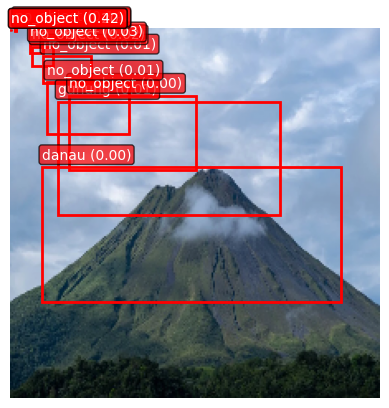

In [ ]:
def predict_and_visualize(image_path, model, class_labels, image_size=224, CONFIDENCE_THRESHOLD=0):
    img = load_and_preprocess_image(image_path)
    img_input = np.expand_dims(img, axis=0)

    pred_bbox, pred_class = model.predict(img_input)
    pred_bbox = pred_bbox[0]
    pred_class = pred_class[0]

    # Ambil label prediksi & confidence
    pred_class_labels = np.argmax(pred_class, axis=-1)
    confidence_scores = np.max(pred_class, axis=-1)

    # Filter hanya bounding box yang valid & confident
    valid_bboxes = []
    valid_class_indices = []
    valid_confidences = []

    for bbox, cls_idx, conf in zip(pred_bbox, pred_class_labels, confidence_scores):
        if np.sum(bbox) > 0 and conf >= CONFIDENCE_THRESHOLD:
            valid_bboxes.append(bbox)
            valid_class_indices.append(int(cls_idx))
            valid_confidences.append(conf)

    # Konversi ke nama kelas
    predicted_class_names = [class_labels[i] for i in valid_class_indices]

    # ✅ Tampilkan hasil
    print("Predicted Class Indices:", valid_class_indices)
    print("Predicted Class Names  :", predicted_class_names)
    print("Confidence Scores       :", valid_confidences)

    # Visualisasi
    plt.imshow(img)
    ax = plt.gca()

    for bbox, class_name, conf in zip(valid_bboxes, predicted_class_names, valid_confidences):
        xmin, ymin, xmax, ymax = bbox * image_size
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   edgecolor='red', facecolor='none', linewidth=2))
        plt.text(xmin, ymin - 5, f"{class_name} ({conf:.2f})", color='white', fontsize=10,
                 bbox=dict(facecolor='red', alpha=0.7, boxstyle='round,pad=0.2'))

    plt.axis('off')
    plt.show()


# Coba prediksi pada gambar baru
predict_and_visualize("/content/drive/MyDrive/Skripsi/Uji/test.jpg", model, class_labels=list(class_mapping.keys()))

In [ ]:
# Ambil contoh gambar dari dataset testing

sample_image = X_val[0]  # Ambil satu gambar
sample_image = np.expand_dims(sample_image, axis=0)  # Tambahkan batch dimension

# Lakukan prediksi
pred_bbox, pred_class = model.predict(sample_image)

# Konversi bounding box ke skala asli jika perlu
pred_bbox = pred_bbox[0]  # Ambil hasil untuk satu gambar
pred_class = pred_class[0]  # Ambil hasil untuk satu gambar


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [ ]:
# Ambil indeks kelas dengan probabilitas tertinggi
pred_class_idx = np.argmax(pred_class, axis=1)  # Jika ada banyak objek

# Konversi ke nama kelas
predicted_classes = [class_labels[idx] for idx in pred_class_idx]

print("Predicted Classes:", predicted_classes)
print("Predicted Bounding Box:\n", pred_bbox)

Predicted Classes: ['danau', 'gunung', 'no_object', 'no_object', 'no_object', 'no_object', 'no_object', 'no_object', 'no_object', 'no_object', 'no_object']
Predicted Bounding Box:
 [[ 9.26404297e-02  4.36241895e-01  1.08876598e+00  8.86052966e-01]
 [ 1.14940152e-01  2.46179372e-01  9.96977448e-01  6.67551994e-01]
 [ 1.70380667e-01  1.95016608e-01  6.27942204e-01  4.64655221e-01]
 [ 9.28426012e-02  1.86078429e-01  3.76816928e-01  3.37516963e-01]
 [ 8.34414363e-02  7.92821199e-02  2.68900305e-01  1.57260269e-01]
 [ 5.88792413e-02  5.13424277e-02  1.19223475e-01  1.05912820e-01]
 [ 6.31030947e-02  5.33315167e-02  9.09235701e-02  6.79347515e-02]
 [ 2.30656117e-02  1.75987184e-03  1.22845471e-02  1.82380602e-02]
 [-4.80321236e-03  1.40299201e-02  1.82914175e-02 -5.00153564e-03]
 [-1.08816875e-02  4.00362257e-03 -7.07252044e-03  3.27430433e-04]
 [ 2.08774442e-03  1.26310997e-03 -8.11744481e-04 -1.67645770e-03]]


In [ ]:
model.save("/content/drive/MyDrive/Skripsi/cnn_object_detection_v2.keras")